In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import os 
import numpy as np
import netCDF4 as nc
import datetime as dt

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle

# credit to T Jarnikova for code bits - thanks!

In [ ]:
# purpose: examine nanoose station data, plot on map, exclude outliers, find centroid of pts
# last modified: March 22, 2023 by GO

In [32]:
# nanoose stn obs data
folder_path = "C:\\temp\\nanoose_prepped\\CTD"  

i = 0
excld = 0
outlr = 0
datasets = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".nc"):
        
        full_file_path = folder_path + "\\" + file_name
        obs = xr.open_dataset(full_file_path)
        obs_coord = obs.get(['latitude','longitude'])
        
        # fix positive lons
        if obs_coord['longitude'] > 0:
            obs_coord['longitude'] = obs_coord['longitude'] * -1
        
        # filter outliers and year
        if obs_coord['latitude'] > 49.45:
            #print("found outlier")
            #print(full_file_path)
            outlr += 1
        elif obs_coord['latitude'] < 49.2:
            #print("found outlier")
            #print(full_file_path)
            outlr += 1
        elif obs_coord['longitude'] < -124.2:
            #print("found outlier")
            #print(full_file_path)
            outlr += 1
        elif obs_coord['longitude'] > -123.8:
            #print("found outlier")
            #print(full_file_path)
            outlr += 1
        elif obs['time'].dt.year < 1970:
            excld += 1
        elif obs['time'].dt.year > 1979:
            excld += 1
        else:
            i += 1
            datasets.append(obs_coord)
        
all_obs_coords = xr.concat(datasets, dim='single')
print(str(i) + " coords found within date range.")
print(str(excld) + " records excluded")
print(str(outlr) + " outliers excluded")

1498 coords found within date range.
4191 records excluded
3 outliers excluded


In [65]:
all_obs_coords.mean()

<xarray.Dataset>
Dimensions:    ()
Data variables:
    latitude   float32 49.33
    longitude  float32 -124.0

In [31]:
# model meshmask - NOT WORKING
f = "..//data//mesh mask//mesh_mask_20210406.nc"

meshmask = xr.open_dataset(f)

meshmask['nav_lat'].stack(z=('x', 'y')).reset_index('z')

<xarray.DataArray 'nav_lat' (z: 39468)>
array([46.864815, 46.87496 , 46.885437, ..., 51.069588, 51.08098 ,
       51.092396], dtype=float32)
Coordinates:
    x        (z) int64 0 0 0 0 0 0 0 0 0 ... 131 131 131 131 131 131 131 131 131
    y        (z) int64 0 1 2 3 4 5 6 7 8 ... 290 291 292 293 294 295 296 297 298
Dimensions without coordinates: z

In [33]:
# inspect the model data points extracted using sample output

folder_path = "C:\\Users\\Greig\\Downloads\\"  
file_name = "SalishSea1500-RUN203_1h_grid_T_y1980m01_clipped.nc"   
full_file_path = folder_path + "\\" + file_name        
mod = xr.open_dataset(full_file_path)
mod_coord = mod.get(['nav_lat','nav_lon'])

C:\Users\Greig\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\Greig\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


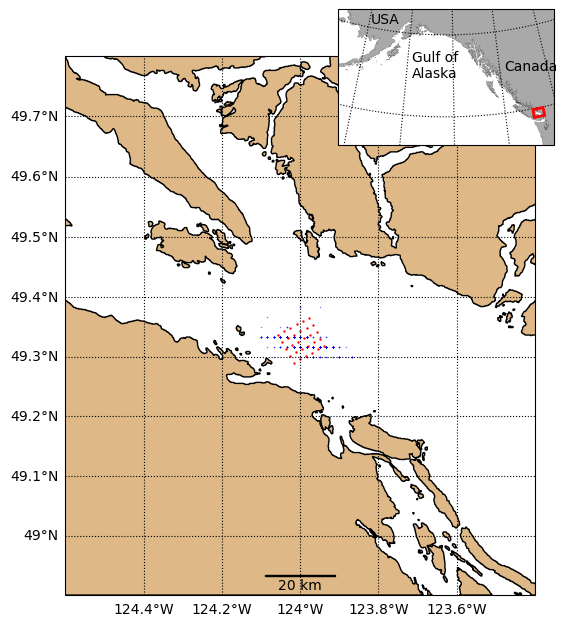

In [27]:
alpha = 0.5 # for point transparency - GO
markersize = 0.7
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


subdomain = [114, 397, 334, 897]
fig = plt.figure(figsize=(9, 7))
gs = plt.GridSpec(1, 1)#, width_ratios=[1.8, 1], wspace=0.13)

# Map Left
xlim, ylim = [-124.6, -123.4], [48.9, 49.8]
ax = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
#full (low for easy render)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
scalebar = AnchoredSizeBar(ax.transData,
                           20000, '20 km', 'lower center', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1)

xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
xlocs = [-123, -123.2, -123.4, -123.6, -123.8, -124, -124.2, -124.4, -124.6, -124.8, -125]
ylocs = [49, 49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50]

gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

ax.add_artist(scalebar)

# ax.text(0.15, 0.1, 'Pacific\nOcean', weight='bold', fontsize = 12, transform=ax.transAxes)
# ax.text(0.32, 0.307, 'Juan de Fuca', weight='bold', transform=ax.transAxes, rotation=-19.5)
# ax.text(0.555, 0.305, 'Strait', weight='bold', transform=ax.transAxes, rotation=10.5)
# ax.text(0.82, 0.18, 'Puget\nSound', weight='bold', transform=ax.transAxes)

# ax.text(0.355, 0.4851, 'Strait of Georgia', weight='bold', transform=ax.transAxes, rotation=-30, color='w')
# #ax.text(0.010, 0.755, 'Johnstone', weight='bold', transform=ax.transAxes, rotation=-20)
# ax.text(0.015, 0.740, 'Johnstone \n Strait ', weight='bold', transform=ax.transAxes, rotation=-0)
# #ax.text(0.16, 0.675, 'Strait', weight='bold', transform=ax.transAxes, rotation=-60)

# ax.text(0.44, 0.38, 'Haro\nStrait', weight='bold', transform=ax.transAxes)
# ax.text(0.72, 0.55, 'Fraser\nRiver', weight='bold', transform=ax.transAxes)
# ax.text(0.35, 0.9, 'Bute Inlet', weight='bold', transform=ax.transAxes)
# ax.text(0.42, 0.80, 'Toba Inlet', weight='bold', transform=ax.transAxes)
# ax.text(0.53, 0.75, 'Jervis Inlet', weight='bold', transform=ax.transAxes)
# ax.text(0.60, 0.67, 'Howe Sound', weight='bold', transform=ax.transAxes)
# ax.text(0.11, 0.64, 'Texada Island', weight='bold',fontstyle="italic", 
#         color = 'k', fontsize = 10, transform=ax.transAxes)

# obs
ax.plot(all_obs_coords['longitude'][:], all_obs_coords['latitude'][:], 'b+', transform=crs.PlateCarree(), alpha=alpha, markersize=markersize)
# clipped model pts
ax.plot(mod_coord['nav_lon'][:], mod_coord['nav_lat'][:], 'ro', transform=crs.PlateCarree(), alpha=1, markersize=markersize)


#Map Inset
xmap, ymap = [-161, -122], [45, 62]
ax2 = fig.add_axes([0.555, 0.75, 0.24, 0.2], projection=crs.LambertConformal(np.mean(xmap), np.mean(ymap)))
ax2.set_extent(xmap + ymap)
ax2.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='darkgray', linewidth=0.1))
ax2.add_patch(Rectangle(
    (xlim[0], ylim[0]), int(np.diff(xlim))+1, int(np.diff(ylim))+1,
    transform=crs.PlateCarree(), fill=False, edgecolor='r', zorder=10, linewidth=2
))

ax2.text(0.34, 0.5, 'Gulf of\nAlaska', transform=ax2.transAxes)
ax2.text(0.77, 0.55, 'Canada', transform=ax2.transAxes)
ax2.text(0.15, 0.9, 'USA', transform=ax2.transAxes)

xticks, yticks = list(range(-170, -100, 10)), list(range(40, 80, 10))
ax2.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
fig.canvas.draw()

#ax.set_title('Nanoose CTD observation location (red) \n on standard Salish Sea map',zorder = 100)

#lct.lambert_xticks(ax, xticks)
#lct.lambert_yticks(ax, yticks)

# # Colorbar
# cax = fig.add_axes([0.15, 0.06, 0.73, 0.025])
# fig.colorbar(c, cax=cax, orientation='horizontal', label='surface diatom concentration (mmol N m$^{-3}$)')

# fig.savefig('./paper_figs/MF01-domain.jpg', bbox_inches='tight', dpi = 300)

In [115]:
all_obs_coords['latitude'][:].min()

<xarray.DataArray 'latitude' ()>
array(49.13333511)

In [29]:
meshmask['nav_lon'][1]

NameError: name 'meshmask' is not defined

In [ ]:
# exploratory code below

In [28]:
meshmask

NameError: name 'meshmask' is not defined